
# 2.2-kW induction motor, diode bridge

A diode bridge, stiff three-phase grid, and a DC link is modeled. The default
parameters in this example yield open-loop V/Hz control.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.8 MB/s eta 0:00:00


In [2]:
import numpy as np

from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, InductionMachineInvGammaPars, InductionMachinePars,
    NominalValues, plot, plot_extra)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

Create the system model.



In [4]:
# Machine model, using its inverse-Γ parameters
mdl_ig_par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
mdl_par = InductionMachinePars.from_inv_gamma_model_pars(mdl_ig_par)
machine = model.InductionMachine(mdl_par)
# Mechanical subsystem with the quadratic load torque profile
k = 1.1*nom.tau/(base.w/base.n_p)**2
mechanics = model.StiffMechanicalSystem(J=.015, B_L=lambda w_M: k*np.abs(w_M))

# Frequency converter with a diode bridge
frequency_converter = model.FrequencyConverter(
    C_dc=235e-6, L_dc=2e-3, U_g=nom.U, f_g=nom.f)
mdl = model.Drive(
    converter=frequency_converter, machine=machine, mechanics=mechanics)
mdl.pwm = model.CarrierComparison()  # Enable the PWM model

Control system (parametrized as open-loop V/Hz control).



In [5]:
# Inverse-Γ model parameter estimates
par = InductionMachineInvGammaPars(R_s=0*3.7, R_R=0*2.1, L_sgm=.021, L_M=.224)
ctrl = control.VHzControl(
    control.VHzControlCfg(par, nom_psi_s=base.psi, k_u=0, k_w=0))

Set the speed reference and the external load torque.



In [6]:
ctrl.ref.w_m = lambda t: (t > .2)*base.w

# Stepwise load torque at t = 1 s, 20% of the rated torque
mdl.mechanics.tau_L = lambda t: (t > 1)*.2*nom.tau

Create the simulation object and simulate it.



In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=1.5)

Plot results in per-unit values.

<div class="alert alert-info"><h4>Note</h4><p>The DC link of this particular example is actually unstable at 1-p.u.
   speed at the rated load torque, since the inverter looks like a negative
   resistance to the DC link. You can notice this instability if simulating a
   longer period (e.g. set `t_stop=2`). For analysis, see e.g., [#Hin2007]_.</p></div>



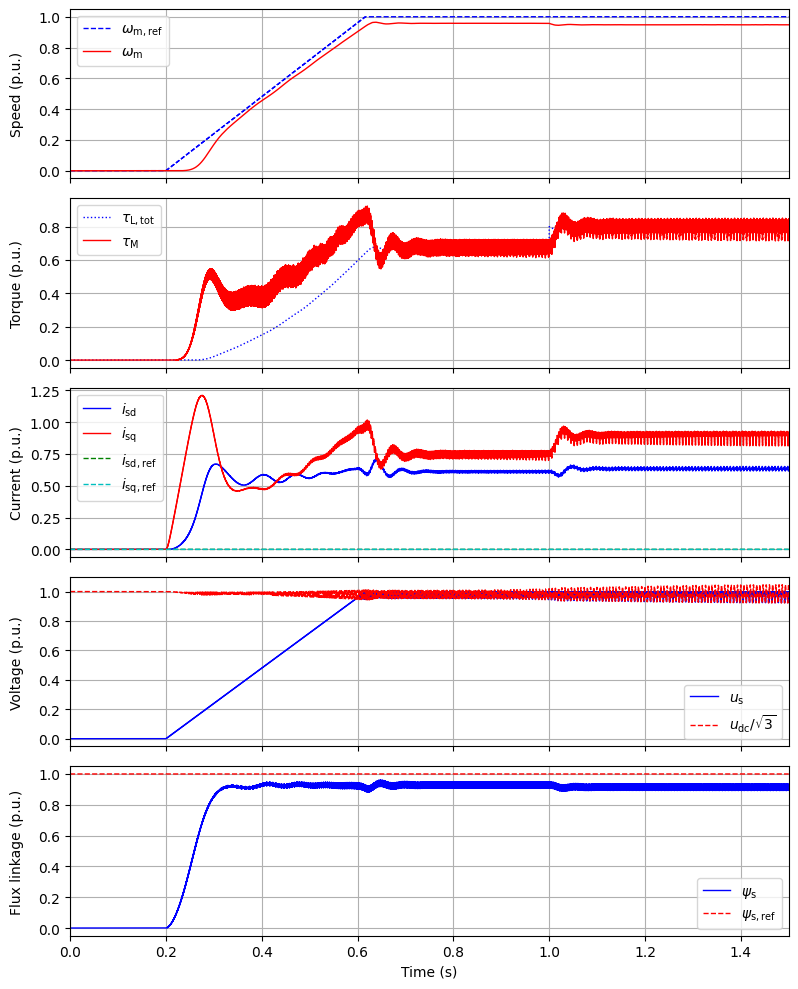

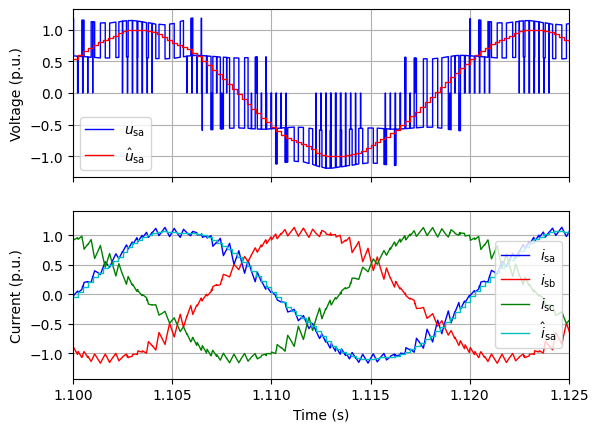

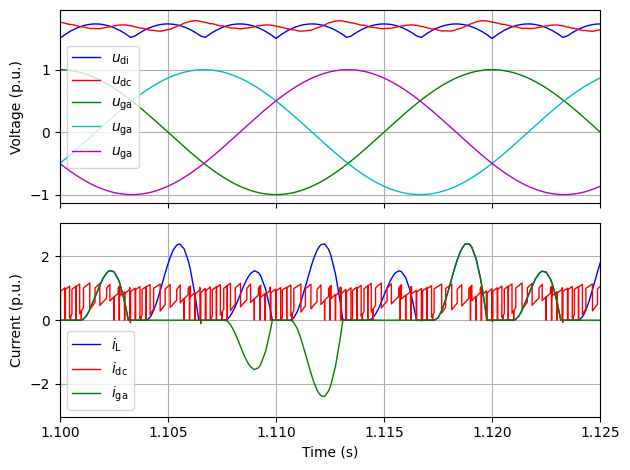

In [8]:
# sphinx_gallery_thumbnail_number = 2
plot(sim, base)
plot_extra(sim, base, t_span=(1.1, 1.125))

.. rubric:: References

.. [#Hin2007] Hinkkanen, Harnefors, Luomi, "Control of induction motor drives
   equipped with small DC-Link capacitance," Proc. EPE, 2007,
   https://doi.org/10.1109/EPE.2007.4417763

